Load libraries

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import warnings
from tqdm import tqdm

PATH =  "/home/jmurga/mkt/201902"
import sys
sys.path.insert(0, PATH + '/scripts/src/')
from mktAnalysis import *

Load main data

In [2]:
dmelDataset  = pd.read_csv(PATH + "/results/dsimDmelSitesBinned.tsv",sep='\t')
humanDataset = pd.read_csv(PATH + "/results/afrEur.tsv",sep='\t')

In [3]:
dmelDataset  = dmelDataset[(dmelDataset.pi != 0 ) & (dmelDataset.p0 != 0) & (dmelDataset.di != 0) & (dmelDataset.d0 != 0) & (dmelDataset.mi != 0) & (dmelDataset.m0 != 0)]
humanDataset = humanDataset[(humanDataset.pi != 0 ) & (humanDataset.p0 != 0) & (humanDataset.di != 0) & (humanDataset.d0 != 0) & (humanDataset.mi != 0) & (humanDataset.m0 != 0)]

In [4]:
%load_ext rpy2.ipython

# Resampling analysis

## Zi

In [ ]:
alphasZi = []
binnedZi = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(np.array([1,2,5,10,25,50,75,100,250,500,750,1000])):
        a, b = sampleAnalysis(df = dmelDataset,population="ZI",sample=i,replicas=1000,dofe=PATH + "/rawData/dofe/pooled",nthreads=20)
        a['bins'] = i; b['bins'] = i
        alphasZi.append(a)
        binnedZi.append(b)
alphasZi = pd.concat(alphasZi)
binnedZi = pd.concat(binnedZi)

In [ ]:
pkl.dump([alphasZi,binnedZi],open(PATH + "/results/pooled/ziPooled.pkl", "wb" ))

**The function *sampleAnalysis* generate the dofe files required to run Grapes. Please check the path where you save the dofe files by bin.**

**Because of the amount of replicas and Grapes execution time, we executed the analysis in an HPC using HTCondor scheduler. Please consider to use an HPC to run these part of the pipeline, otherwise consider to use GNU-Parallel to run the replicas. The next cells contains a submission file example considering the 1000 bin folder. We moved the dofe folder to perform the analysis**

```bash 

executable=/data/bioinfo/software/grapes/grapes
arguments="-in /nfs/pic.es/user/j/jmurgamo/dofe/pooled/zi/1000/$(Item)_concat.dofe -out /nfs/pic.es/user/j/jmurgamo/dofe/pooled/zi/1000/$(Item)_concat.GammaZero -model GammaZero"

error = err/err.grapes.$(Item)
log = log/log.grapes.$(Item)

queue 1 from seq 1 1000 |

```

**Execute grapes before continue**

In [ ]:
df = list()
for i in np.array([1,2,5,10,25,50,75,100,250,500,750,1000]):
    tmp = grapesOutput(PATH + "/rawData/dofe/pooled/zi/"+str(i)+"/bootstrap/","GammaZero",7)
    tmp['bins'] = i
    tmp['pop']  = 'ZI'
    df.append(tmp)
grapesZi = pd.concat(df)
grapesZi.to_csv(PATH + "/results/pooled/bootstrap/grapesBootstrapZi.tsv",sep='\t',index=False)

## Afr

In [50]:
alphasAfr = []
binnedAfr = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(np.array([1,2,5,10,25,50,75,100,250,500,750,1000])):
        a, b = sampleAnalysis(df = humanDataset,population="AFR",sample=i,replicas=1000,dofe=PATH + "/rawData/dofe/pooled",nthreads=8)
        alphasAfr.append(a)
        binnedAfr.append(b)
alphasAfr = pd.concat(alphasAfr)
binnedAfr = pd.concat(binnedAfr)

100%|██████████| 1/1 [01:10<00:00, 70.38s/it]


In [44]:
pkl.dump([alphasAfr,binnedAfr],open(PATH + "/results/pooled/afrPooled.pkl", "wb" ))

**The function *sampleAnalysis* generate the dofe files required to run Grapes. Please check the path where you save the dofe files by bin.**

**Because of the amount of replicas and Grapes execution time, we executed the analysis in an HPC using HTCondor scheduler. Please consider to use an HPC to run these part of the pipeline, otherwise consider to use GNU-Parallel to run the replicas. The next cells contains a submission file example considering the 1000 bin folder. We moved the dofe folder to perform the analysis**

```bash 

executable=/data/bioinfo/software/grapes/grapes
arguments="-in /nfs/pic.es/user/j/jmurgamo/dofe/pooled/afr/1000/$(Item)_concat.dofe -out /nfs/pic.es/user/j/jmurgamo/dofe/pooled/afr/1000/$(Item)_concat.GammaZero -model GammaZero"

error = err/err.grapes.$(Item)
log = log/log.grapes.$(Item)

queue 1 from seq 1 1000 |

```

# Plot

Loading data from pickle and formating to plot in R

In [5]:
alphas, binned = loadPickleAlphas(PATH + "/results/pooled/*.pkl")

## ZI

In [6]:
alphasZi = alphas['zi']; binnedZi = binned['zi']

In [7]:
grapesPooledZi = []
for i in tqdm(np.array(glob.glob(PATH + "/rawData/dofe/pooled/zi/*"))):
    tmp,tmp2,tmp3 = grapesOutput(i,"GammaZero","ZI",5)
    tmp['bins'] = int(i.split('/')[-1])
    tmp['pop'] = 'ZI'
    grapesPooledZi.append(tmp)
grapesPooledZi = pd.concat(grapesPooledZi)
grapesPooledZi.sort_values('bins',inplace=True)

100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


In [8]:
dfZi = pd.concat([pd.melt(grapesPooledZi,id_vars=['test','bins','pop'],value_vars='alpha'),alphasZi])
dfZi.bins = dfZi.bins.astype(str)
dfZi.bins = pd.Categorical(dfZi.bins,categories=dfZi.bins.unique())

In [9]:
a = dfZi.groupby(['test','bins']).value.var().reset_index()

In [12]:
grapesCountZi = grapesPooledZi.groupby(['test','bins','pop']).alpha.count().reset_index()

R[write to console]: Saving 14 x 6.67 in image



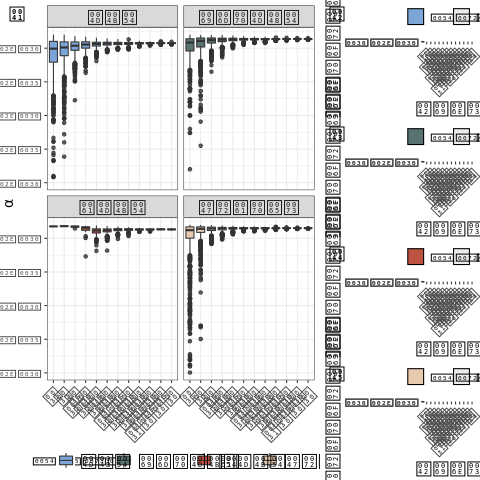

In [28]:
%%R -i binnedZi -i dfZi -i grapesPooledZi -i grapesCountZi -i PATH

library(cowplot)

binnedZi = as.data.table(binnedZi)
grapesPooledZi = as.data.table(grapesPooledZi)
grapesPooledZi[['bins']] = as.factor(grapesPooledZi[['bins']])
dfZi = as.data.table(dfZi)


#ci = ggplot(grapesPooledZi,aes(x = bins, y = alpha_range, fill=bins)) + geom_boxplot(show.legend=F) + labs(x = "Bins", y=expression(paste('CI ',alpha))) + theme_bw() + scale_fill_manual(values=c(rep("#e2bd9a",length(grapesPooledZi[['bins']])))) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=90),axis.text.y = element_text(size=12),axis.title=element_text(size=14)) + ggtitle("") + geom_hline(yintercept=0.25,linetype='dashed') 

d = dfZi[test == 'std' | test == 'imp2' | test == 'asymp2' | test == 'grapes']
d$test = factor(d$test,levels=c('std','imp2','asymp2','grapes'))
levels(d$test) = c('MKT','impMKT','aMKT','Grapes')

p = ggplot(d) + geom_boxplot(aes(x = bins, y = value, fill=test),alpha=0.8,show.legend=T) + labs(x='',y=expression(alpha)) + theme_bw()  + scale_fill_manual(values=c("#5C8FCE","#30504f","#ab2710","#e2bd9a"),name = "Test", labels = c("MKT","impMKT", "aMKT","Grapes")) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=14,angle=45,hjust=1,vjust=1),axis.title=element_text(size=14),legend.position="bottom",legend.text=element_text(size=14))
p = p + facet_wrap(~test) + ylim(-10,1)

fraction_original = binnedZi[test=='std']
fraction_original[['TRUE']] = fraction_original[['count']]/1000
fraction_original[['FALSE']]= 1 - fraction_original[['TRUE']]
fraction_original = melt(fraction_original,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction_original = ggplot(fraction_original) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#5C8FCE","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

fraction = binnedZi[test=='imp2']
fraction[['TRUE']] = fraction[['count']]/1000
fraction[['FALSE']]= 1 - fraction[['TRUE']]
fraction = melt(fraction,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction = ggplot(fraction) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#30504f","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

fraction2 = binnedZi[test=='asymp1']
fraction2[['TRUE']] = fraction2[['count']]/1000
fraction2[['FALSE']]= 1 - fraction2[['TRUE']]
fraction2 = melt(fraction2,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction2 = ggplot(fraction2) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#ab2710","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

names(grapesCountZi)[4] = 'count'

fraction3 = grapesCountZi
fraction3[['TRUE']] = fraction3[['count']]/1000
fraction3[['FALSE']]= 1 - fraction3[['TRUE']]
fraction3 = melt(fraction3,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))


pFraction3 = ggplot(fraction3) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#e2bd9a","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))


tmp = plot_grid(pFraction_original,pFraction,pFraction2,pFraction3,ncol = 1,rel_heights = c(1,1,1,1),labels=c('B','C','D','E'))

pgrid = plot_grid(p,tmp,ncol=2,rel_widths = c(2, 1),labels=c('A',''))

ggsave(pgrid,filename=paste0("/home/jmurga/zi_pooled_v4.svg"),dpi=600,width=14)
#ggsave(pgrid,filename=paste0(PATH,"/results/pooled/ziPooled_v3.svg"),dpi=600,width=14)
#ggsave(pgrid,filename=paste0(PATH,"/results/pooled/ziPooled_v3.png"),dpi=600,width=14)
pgrid


## AFR

In [29]:
alphasAfr = alphas['afr']; binnedAfr = binned['afr']

In [32]:
grapesPooledAfr = []
for i in tqdm(np.array(glob.glob(PATH + "/rawData/dofe/pooled/afr/*"))):
    print(i)
    tmp,tmp2,tmp3 = grapesOutput(i,"GammaZero","afr",5)
    tmp['bins'] = int(i.split('/')[-1])
    tmp['pop'] = 'AFR'
    grapesPooledAfr.append(tmp)
grapesPooledAfr = pd.concat(grapesPooledAfr)
grapesPooledAfr.sort_values('bins',inplace=True)

  0%|          | 0/12 [00:00<?, ?it/s]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/2


  8%|▊         | 1/12 [00:04<00:54,  4.93s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/10


 17%|█▋        | 2/12 [00:09<00:50,  5.01s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/5


 25%|██▌       | 3/12 [00:15<00:48,  5.38s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/100


 33%|███▎      | 4/12 [00:21<00:42,  5.37s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/25


 42%|████▏     | 5/12 [00:27<00:39,  5.65s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/500


 50%|█████     | 6/12 [00:32<00:33,  5.53s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/1000


 58%|█████▊    | 7/12 [00:37<00:26,  5.39s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/1


 67%|██████▋   | 8/12 [00:42<00:21,  5.31s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/50


 75%|███████▌  | 9/12 [00:48<00:16,  5.34s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/75


 83%|████████▎ | 10/12 [00:53<00:10,  5.44s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/750


 92%|█████████▏| 11/12 [01:00<00:05,  5.68s/it]

/home/jmurga/mkt/201902/rawData/dofe/pooled/afr/250


100%|██████████| 12/12 [01:06<00:00,  5.52s/it]


In [33]:
dfAfr = pd.concat([pd.melt(grapesPooledAfr,id_vars=['test','bins','pop'],value_vars='alpha'),alphasAfr])
dfAfr.bins = dfAfr.bins.astype(str)
dfAfr.bins = pd.Categorical(dfAfr.bins,categories=dfAfr.bins.unique())

In [34]:
grapesCountAfr = grapesPooledAfr.groupby(['test','bins','pop']).alpha.count().reset_index()

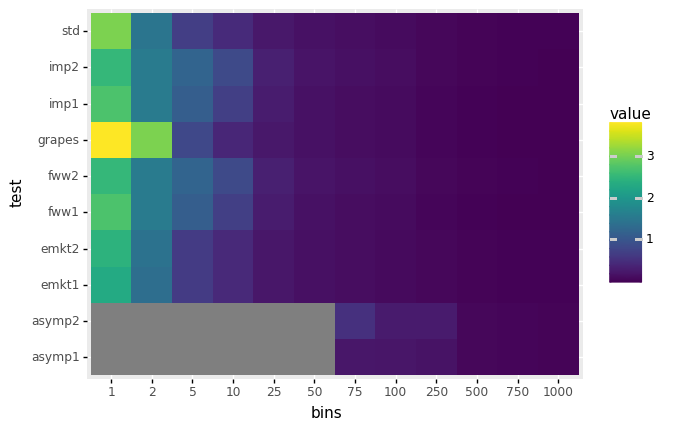

<ggplot: (8749341213784)>

In [77]:
b = dfAfr.groupby(['test','bins']).value.std().reset_index()

b = b[b.test!='nan']
ggplot(b,aes(x='bins',y='test',fill='value')) + geom_tile() 

R[write to console]: Saving 14 x 6.67 in image



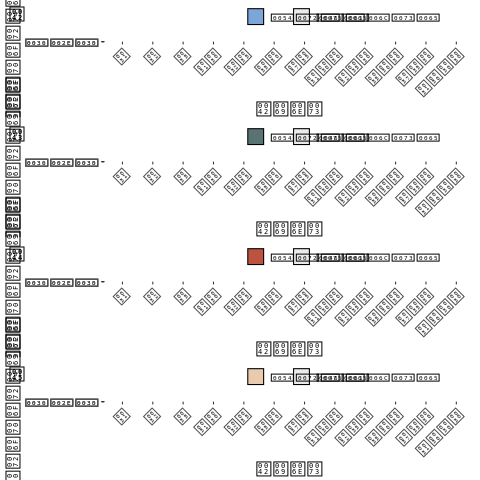

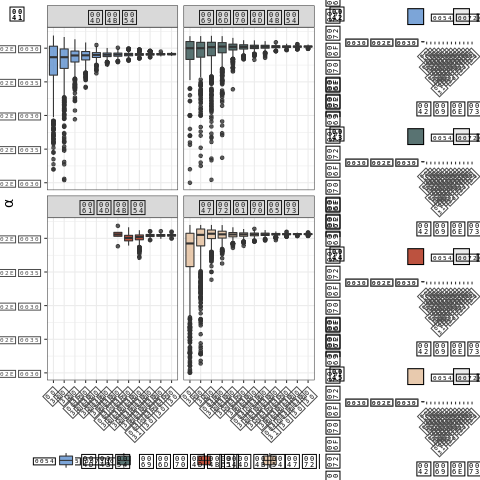

In [48]:
%%R -i binnedAfr -i dfAfr -i grapesPooledAfr -i grapesCountAfr -i PATH

library(cowplot)

binnedAfr = as.data.table(binnedAfr)
grapesPooledAfr = as.data.table(grapesPooledAfr)
grapesPooledAfr[['bins']] = as.factor(grapesPooledAfr[['bins']])
dfAfr = as.data.table(dfAfr)


d = dfAfr[test == 'std' | test == 'imp2' | test == 'asymp2' | test == 'grapes']
d$test = factor(d$test,levels=c('std','imp2','asymp2','grapes'))
levels(d$test) = c('MKT','impMKT','aMKT','Grapes')

p = ggplot(d) + geom_boxplot(aes(x = bins, y = value, fill=test),alpha=0.8,show.legend=T) + labs(x='',y=expression(alpha)) + theme_bw()  + scale_fill_manual(values=c("#5C8FCE","#30504f","#ab2710","#e2bd9a"),name = "Test", labels = c("MKT","impMKT", "aMKT","Grapes")) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=14,angle=45,hjust=1,vjust=1),axis.title=element_text(size=14),legend.position="bottom",legend.text=element_text(size=14))
p = p + facet_wrap(~test) + ylim(-10,1)

fraction_original = binnedAfr[test=='std']
fraction_original[['TRUE']] = fraction_original[['count']]/1000
fraction_original[['FALSE']]= 1 - fraction_original[['TRUE']]
fraction_original = melt(fraction_original,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction_original = ggplot(fraction_original) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#5C8FCE","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

fraction = binnedAfr[test=='imp2']
fraction[['TRUE']] = fraction[['count']]/1000
fraction[['FALSE']]= 1 - fraction[['TRUE']]
fraction = melt(fraction,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction = ggplot(fraction) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#30504f","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

fraction2 = binnedAfr[test=='asymp1']
fraction2[['TRUE']] = fraction2[['count']]/1000
fraction2[['FALSE']]= 1 - fraction2[['TRUE']]
fraction2 = melt(fraction2,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction2 = ggplot(fraction2) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#ab2710","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

names(grapesCountAfr)[4] = 'count'

fraction3 = grapesCountAfr
fraction3[['TRUE']] = fraction3[['count']]/1000
fraction3[['FALSE']]= 1 - fraction3[['TRUE']]
fraction3 = melt(fraction3,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))


pFraction3 = ggplot(fraction3) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#e2bd9a","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))


tmp = plot_grid(pFraction_original,pFraction,pFraction2,pFraction3,ncol = 1,rel_heights = c(1,1,1,1),labels=c('B','C','D','E'))

print(tmp)

pgrid = plot_grid(p,tmp,ncol=2,rel_widths = c(2, 1),labels=c('A',''))

ggsave(pgrid,filename=paste0("/home/jmurga/afr_pooled_v4.svg"),dpi=600,width=14)
#ggsave(pgrid,filename=paste0(PATH,"/results/pooled/ziPooled_v3.svg"),dpi=600,width=14)
#ggsave(pgrid,filename=paste0(PATH,"/results/pooled/ziPooled_v3.png"),dpi=600,width=14)
pgrid

In [1]:
tmp = pd.concat([dfZi,dfAfr]).groupby(['test','bins','pop']).value.describe(percentiles=[0.05,0.5,0.95]).reset_index();tmp

NameError: name 'pd' is not defined

In [57]:
df = tmp[(tmp.test == 'imp2') | (tmp.test == 'asymp1') | (tmp.test == 'grapes')]
tmpCi = np.round(df[['mean']],3).astype(str).values + " (" + np.round(df[['5%']],3).astype(str).values + " - " + np.round(df[['95%']],3).astype(str) + ")"
dfPooled = pd.concat([df.loc[:,['test','pop','bins']],tmpCi],axis=1)

dfPooled['pop'] = dfPooled['pop'].str.upper()

dfPooled = pd.pivot_table(dfPooled.sort_values(['pop','test','bins']),index=['pop','test'],columns='bins',values=['95%'],aggfunc=lambda x: ' '.join(x))

dfPooled.to_csv(PATH + "/results/pooled/dfPooled.tsv",sep='\t',index=True)

In [86]:
tmp = pd.concat([dfZi,dfAfr])
a = tmp[(tmp.test=='imp2') | (tmp.test == 'asymp1')].groupby(['test','bins','pop']).value.describe(percentiles=[0.05,0.5,0.95]).reset_index()

In [122]:
grapesPooled = pd.concat([grapesPooledZi,grapesPooledAfr])
grapesPooled['pop'] = grapesPooled['pop'].str.upper()

b = grapesPooled[(grapesPooled.alpha_range < 0.25) & (grapesPooled.alpha_range != 0)].groupby(['test','bins','pop']).alpha_range.describe(percentiles=[0.05,0.5,0.95]).reset_index()

In [123]:
c = pd.concat([a,b]).sort_values(['pop'],ascending=False)
c.bins = c.bins.astype(int)

In [142]:
%%R -i c -i PATH

c = as.data.table(c)
d = c[with(c, order(-pop, test,bins)), ]
d[,4:ncol(d)] = round(d[,4:ncol(d)],3)
d[,4] = d[,4]/1000

fwrite(d,paste0(PATH,"/results/pooled/pooledCounts.tsv"),sep='\t')
d

      test bins pop count   mean   std     min     5%    50%   95%   max
 1: asymp1    1  ZI 0.001  0.888   NaN   0.888  0.888  0.888 0.888 0.888
 2: asymp1    2  ZI 0.003  0.876 0.017   0.864  0.865  0.868 0.894 0.896
 3: asymp1    5  ZI 0.006  0.849 0.026   0.816  0.817  0.854 0.877 0.880
 4: asymp1   10  ZI 0.026  0.661 0.376  -0.941  0.250  0.809 0.864 0.980
 5: asymp1   25  ZI 0.413  0.560 0.211  -0.414  0.170  0.597 0.821 0.951
 6: asymp1   50  ZI 0.913  0.600 0.135  -0.265  0.352  0.623 0.775 0.877
 7: asymp1   75  ZI 0.961  0.628 0.100   0.102  0.448  0.640 0.767 0.860
 8: asymp1  100  ZI 0.976  0.634 0.086   0.230  0.482  0.642 0.762 0.824
 9: asymp1  250  ZI 0.995  0.645 0.055   0.459  0.544  0.649 0.729 0.779
10: asymp1  500  ZI 1.000  0.650 0.040   0.502  0.583  0.653 0.709 0.746
11: asymp1  750  ZI 1.000  0.654 0.033   0.538  0.595  0.658 0.703 0.732
12: asymp1 1000  ZI 1.000  0.656 0.027   0.553  0.607  0.658 0.696 0.722
13: grapes    1  ZI 0.006  0.202 0.046   0.115  0.1